In [1]:
import certifi
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import quantstats as qs 
from fredapi import Fred
from urllib.request import urlopen
from functions.utils.func import *

# Params

In [2]:
live = True
start_date = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')
scale = 10
window = 3

In [4]:
get_adj_factor(['AAPL'], '2005-01-03')

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94ticker/s]


,,adj_factor
ticker,date,
AAPL,2005-01-03,0.847814


In [5]:
past_price = pd.read_parquet(get_strategy_port_data() / 'data_price.parquet.brotli')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Jonathan\\QuantResearch\\AlgoTradingModels\\algofacto\\live\\strategy_port\\data\\data_price.parquet.brotli'

In [71]:
# Get return data
def get_ret(ticker_list, start_date, current_date):
    data = get_data_fmp(ticker_list=ticker_list, start=start_date, current_date=current_date)
    data = data[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
    data = data.rename(columns={'Adj Close': 'Close'})
    data = create_return(data, [1])
    data = data.loc[~data.index.duplicated(keep='first')]
    data_copy = data.copy(deep=True)
    ret = data_copy.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
    ret = ret.fillna(0)
    price = data_copy[['Close']]
    return ret, price

def add_weight(df, mask, scale, weight_ticker, non_weight_ticker):
    data = df.copy(deep=True)
    # Adjust weights
    for date in data[mask].index:
        # Scale up the stock ticker weights
        for stock in weight_ticker:
            current_weight = data.at[date, stock]
            scale_up_factor = 1 + (scale * current_weight)
            data.at[date, stock] *= scale_up_factor

        # Scale down the non-stock ticker weights
        for non_stock in non_weight_ticker:
            current_weight = data.at[date, non_stock]
            scale_down_factor = 1 - (scale * current_weight)
            data.at[date, non_stock] *= max(0, scale_down_factor)

        # Normalize the weights for the date
        data.loc[date] = data.loc[date] / data.loc[date].sum()
    return data

def get_macro(port, item, name):
    fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
    data = fred.get_series(item).to_frame()
    data.columns = [name]
    date = port.drop(port.columns, axis=1)
    date = date.reset_index()
    data = data.reset_index()
    data = pd.merge_asof(date, data, left_on='date', right_on='index', direction='backward')
    data = data.set_index('date').drop('index', axis=1)
    data = data.ffill()
    return data

# Past

In [72]:
# Get commodity data
com_ticker = ['GLD', 'SLV', 'PDBC', 'USO', 'AMLP', 'XOP']
com_ret, com_price = get_ret(com_ticker, start_date, current_date)
# Get bond data
bond_ticker = ['BND', 'AGG', 'BNDX', 'VCIT', 'MUB', 'VCSH', 'BSV', 'VTEB', 'IEF', 'MBB', 'GOVT', 'VGSH', 'IUSB', 'TIP']
bond_ret, bond_price = get_ret(bond_ticker, start_date, current_date)
# Get technology data
tech_ticker = ['QQQ', 'SMH', 'ARKK', 'KWEB', 'CIBR']
tech_ret, tech_price = get_ret(tech_ticker, start_date, current_date)
# Get energy data
eng_ticker = ['XLE', 'AMJ', 'ICLN']
eng_ret, eng_price = get_ret(eng_ticker, start_date, current_date)
# Get healthcare data
hc_ticker = ['XLV', 'IBB', 'ARKG']
hc_ret, hc_price = get_ret(hc_ticker, start_date, current_date)
# Get real estate data
re_ticker = ['VNQ', 'VNQI', 'RWO']
re_ret, re_price = get_ret(re_ticker, start_date, current_date)
# Get materials data
mat_ticker = ['XLB', 'GDX', 'GNR', 'LIT', 'URA', 'ITB', 'XME']
mat_ret, mat_price = get_ret(mat_ticker, start_date, current_date)
# Get financials data
fin_ticker = ['XLF', 'KRE', 'EUFN']
fin_ret, fin_price = get_ret(fin_ticker, start_date, current_date)
# Get consumer discretionary data
cd_ticker = ['XLY', 'XLC', 'FXD']
cd_ret, cd_price = get_ret(cd_ticker, start_date, current_date)
# Get industry data
ind_ticker = ['XLI', 'XAR', 'FXR']
ind_ret, ind_price = get_ret(ind_ticker, start_date, current_date)
# Get utilities data
util_ticker = ['XLU', 'PAVE', 'IGF', 'JETS']
util_ret, util_price = get_ret(util_ticker, start_date, current_date)
# Get consumer staples data
cp_ticker = ['XLP', 'IEV']
cp_ret, cp_price = get_ret(cp_ticker, start_date, current_date)
port = pd.concat([com_ret, bond_ret, tech_ret, eng_ret, hc_ret, re_ret, mat_ret, fin_ret, cd_ret, ind_ret, util_ret, cp_ret], axis=0)
price = pd.concat([com_price, bond_price, tech_price, eng_price, hc_price, re_price, mat_price, fin_price, cd_price, ind_price, util_price, cp_price], axis=0)
port = port.unstack('ticker')
price = price.unstack('ticker')
port.columns = port.columns.get_level_values('ticker')
price.columns = price.columns.get_level_values('ticker')
port.to_parquet(get_strategy_port_data() / 'data_port.parquet.brotli', compression='brotli')
price.to_parquet(get_strategy_port_data() / 'data_price.parquet.brotli', compression='brotli')

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05ticker/s]


In [63]:
def create_weight(live, port, tech_ticker, eng_ticker, hc_ticker, re_ticker, mat_ticker, fin_ticker, cd_ticker, 
                  ind_ticker, util_ticker, cp_ticker, com_ticker, bond_ticker):
    
    # Inverse Volatility Weights
    if live == True:
        print("Calculate inverse vol weights...")
        vol = port.tail(3).std()
        vol = vol.to_frame().T
        vol.index = [pd.to_datetime(current_date)]
        vol.index.names = ['date']
        inv_vol = 1 / vol
        inv_vol_weight = inv_vol.div(inv_vol.sum(axis=1), axis=0)
    else:
        print("Calculate inverse vol weights...")
        vol = port.rolling(window=window).std()
        inv_vol = 1 / vol
        inv_vol_weight = inv_vol.div(inv_vol.sum(axis=1), axis=0)
    
    # Sector vs. Commodity & Bonds
    stock_ticker = tech_ticker + eng_ticker + hc_ticker + re_ticker + mat_ticker + fin_ticker + cd_ticker + ind_ticker + util_ticker + cp_ticker
    non_stock_ticker = com_ticker + bond_ticker
    
    # Beginning of the month for each date
    print("Calculate beginning of month weights...")
    beginning_of_month = inv_vol_weight.index.to_series().apply(lambda x: x.replace(day=1))
    # Mask for the first week of each month
    first_week_mask = (inv_vol_weight.index - beginning_of_month) < pd.Timedelta('7 days')
    # Add weight
    inv_month_weight = add_weight(inv_vol_weight, first_week_mask, scale, stock_ticker, non_stock_ticker)

    # Last day of each month
    print("Calculate last week of December weights...")
    last_day_of_month = inv_month_weight.index.to_series().apply(lambda x: x.replace(day=1) + pd.offsets.MonthEnd(1))
    # Neginning of the last week of each month
    beginning_of_last_week = last_day_of_month - pd.Timedelta(days=6)
    # Mask for the last week of the year (December)
    is_year_end_week_mask = ((inv_month_weight.index >= beginning_of_last_week) & 
                        (inv_month_weight.index <= last_day_of_month) & 
                        (inv_month_weight.index.month == 12))
    # Add Weight
    inv_end_weight = add_weight(inv_month_weight, is_year_end_week_mask, scale, stock_ticker, non_stock_ticker)
    
    # Mask for September
    print("Calculate September weights...")
    is_september_mask = inv_end_weight.index.month.isin([9])
    # Add Weight
    inv_sept_weight = add_weight(inv_end_weight, is_september_mask, scale, non_stock_ticker, stock_ticker)
    
    # Mask for Halloween
    print("Calculate Halloween weights...")
    is_hall_mask = inv_sept_weight.index.month.isin([10, 11, 12])
    # Add Weight
    inv_hall_weight = add_weight(inv_sept_weight, is_hall_mask, scale, stock_ticker, non_stock_ticker)

    # Get Inflation Data
    print("Get Inflation data...")
    inflation = get_macro(port, 'T5YIE', '5YIF')
    print("Export data...")
    inflation.to_parquet(get_strategy_port_data() / 'data_if.parquet.brotli', compression='brotli')
    # High inflation tickers
    print("Calculate high inflation weights...")
    hinf_ticker = bond_ticker + com_ticker + cp_ticker + eng_ticker + util_ticker
    non_hinf_ticker = tech_ticker + re_ticker + mat_ticker + fin_ticker + cd_ticker + ind_ticker + hc_ticker
    # Mask for the high inflation dates
    high_inflation = inflation.loc[inflation['5YIF'] > 2.75]
    high_inflation_mask = (inv_hall_weight.index.isin(high_inflation.index))
    # Add Weight
    inv_hif_weight = add_weight(inv_hall_weight, high_inflation_mask, scale, hinf_ticker, non_hinf_ticker)
    
    # Low inflation tickers
    print("Calculate low inflation weights...")
    low_inflation = inflation.loc[inflation['5YIF'] < 0.75]
    linf_ticker = bond_ticker + cd_ticker + tech_ticker + fin_ticker
    non_linf_ticker = re_ticker + mat_ticker + ind_ticker + util_ticker + hc_ticker + cp_ticker + eng_ticker + com_ticker
    # Mask for the low inflation dates
    low_inflation_mask = (inv_hif_weight.index.isin(low_inflation.index))
    # Add Weight
    inv_lif_weight = add_weight(inv_hif_weight, low_inflation_mask, scale, linf_ticker, non_linf_ticker)
    
    # Get Interest Rate
    print("Get Interest data...")
    interest = get_macro(port, 'REAINTRATREARAT10Y', 'rIR')
    print("Export data...")
    interest.to_parquet(get_strategy_port_data() / 'data_ir.parquet.brotli', compression='brotli')
    # High interest ticker
    print("Calculate high interest weights...")
    hir_ticker = com_ticker + cp_ticker + eng_ticker + util_ticker + fin_ticker
    non_hir_ticker = tech_ticker + re_ticker + mat_ticker + cd_ticker + ind_ticker + hc_ticker + bond_ticker
    # Mask for the high interest dates
    high_interest = interest.loc[interest['rIR'] > 1.25]
    high_interest_mask = (inv_lif_weight.index.isin(high_interest.index))
    # Add Weight
    inv_hir_weight = add_weight(inv_lif_weight, high_inflation_mask, scale, hir_ticker, non_hir_ticker)
    # Low interest ticker
    print("Calculate low interest weights...")
    lir_ticker = fin_ticker + re_ticker + cd_ticker
    non_lir_ticker = tech_ticker + mat_ticker + hc_ticker + cp_ticker + com_ticker + eng_ticker + util_ticker + bond_ticker + ind_ticker
    # Create a mask for the low interest dates
    low_interest = interest.loc[interest['rIR'] < 0.25]
    low_interest_mask = (inv_hir_weight.index.isin(low_interest.index))
    # Add Weight
    inv_lir_weight = add_weight(inv_hir_weight, low_interest_mask, scale, lir_ticker, non_lir_ticker)
    
    # Get FFund Rate
    print("Get FFund data...")
    ffund = get_macro(port, 'FEDFUNDS', 'FF')
    print("Export data...")
    ffund.to_parquet(get_strategy_port_data() / 'data_ffund.parquet.brotli', compression='brotli')
    # High FFund rate ticker
    print("Calculate high ffund weights...")
    hff_ticker = cp_ticker + util_ticker + fin_ticker + hc_ticker + ind_ticker
    non_hff_ticker = tech_ticker + re_ticker + mat_ticker + cd_ticker + eng_ticker + bond_ticker + com_ticker
    # Mask for the high ffund dates
    high_ff = ffund.loc[ffund['FF'] > 3.0]
    high_ff_mask = (inv_lir_weight.index.isin(high_ff.index))
    # Add Weight
    inv_hff_weight = add_weight(inv_lir_weight, high_ff_mask, scale, hff_ticker, non_hff_ticker)
    # Low FFund rate ticker
    print("Calculate low ffund weights...")
    lff_ticker = re_ticker + cd_ticker
    non_lff_ticker = tech_ticker + mat_ticker + eng_ticker + bond_ticker + com_ticker + cp_ticker + util_ticker + hc_ticker + ind_ticker + fin_ticker
    # Mask for the low ffund dates
    low_ff = ffund.loc[ffund['FF'] < 0.50]
    low_ff_mask = (inv_hff_weight.index.isin(low_ff.index))
    # Add Weight
    inv_lff_weight = add_weight(inv_hff_weight, low_ff_mask, scale, lff_ticker, non_lff_ticker)
    
    # Get unemployment
    print("Get unemployment data...")
    unemploy = get_macro(port, 'UNRATE', 'UR')
    unemploy.to_parquet(get_strategy_port_data() / 'data_ur.parquet.brotli', compression='brotli')
    # High employment ticker
    print("Calculate high unemployment weights...")
    hur_ticker = cp_ticker + util_ticker + hc_ticker + tech_ticker + ind_ticker
    non_hur_ticker = re_ticker + mat_ticker + cd_ticker + eng_ticker + bond_ticker + com_ticker + fin_ticker 
    # Mask for high employment 
    high_ur = unemploy.loc[unemploy['UR'] > 10.0]
    high_ur_mask = (inv_lff_weight.index.isin(high_ur.index))
    # Add Weight
    inv_hur_weight = add_weight(inv_lff_weight, high_ur_mask, scale, hur_ticker, non_hur_ticker)

    # Export Weight
    print("Export weight...")
    inv_hur_weight.to_parquet(get_strategy_port_data() / 'data_weight.parquet.brotli', compression='brotli')
    
    # Export ticker list
    ticker_categories = {
        'cp': cp_ticker,
        'util': util_ticker,
        'hc': hc_ticker,
        'tech': tech_ticker,
        'ind': ind_ticker,
        're': re_ticker,
        'mat': mat_ticker,
        'cd': cd_ticker,
        'eng': eng_ticker,
        'bond': bond_ticker,
        'com': com_ticker,
        'fin': fin_ticker
    }
    
    df_tickers = pd.DataFrame([(ticker, category) for category, tickers in ticker_categories.items() for ticker in tickers], columns=['ticker', 'category'])
    df_tickers = df_tickers.set_index('ticker')
    print("Export tickers...")
    df_tickers.to_parquet(get_strategy_port_data() / 'data_stock.parquet.brotli', compression='brotli')
    return inv_hur_weight

In [64]:
past_weight = create_weight(live=False, port=port, tech_ticker=tech_ticker, eng_ticker=eng_ticker, hc_ticker=hc_ticker, 
                            re_ticker=re_ticker, mat_ticker=mat_ticker, fin_ticker=fin_ticker, cd_ticker=cd_ticker, 
                            ind_ticker=ind_ticker, util_ticker=util_ticker, cp_ticker=cp_ticker, com_ticker=com_ticker, bond_ticker=bond_ticker)

Calculate inverse vol weights...
Calculate beginning of month weights...
Calculate last week of December weights...
Calculate September weights...
Calculate Halloween weights...
Get Inflation data...
Export data...
Calculate high inflation weights...
Calculate low inflation weights...
Get Interest data...
Export data...
Calculate high interest weights...
Calculate low interest weights...
Get FFund data...
Export data...
Calculate high ffund weights...
Calculate low ffund weights...
Get unemployment data...
Calculate high unemployment weights...
Export weight...
Export tickers...


[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-01-05   2005-01-05
End Period                 2023-11-13   2023-11-13
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       97.0%

Cumulative Return          270.44%      347.68%
CAGR﹪                     4.91%        5.64%

Sharpe                     0.46         0.77
Prob. Sharpe Ratio         97.57%       99.95%
Smart Sharpe               0.42         0.7
Sortino                    0.64         1.07
Smart Sortino              0.58         0.97
Sortino/√2                 0.45         0.75
Smart Sortino/√2           0.41         0.69
Omega                      1.18         1.18

Max Drawdown               -56.47%      -39.32%
Longest DD Days            1982         897
Volatility (ann.)          19.41%       11.17%
R^2                        0.7          0.7
Information Ratio          -0.0         -0.0
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-05-21,2008-11-20,2010-11-03,897,-39.319386,-34.863055
2,2020-03-05,2020-03-23,2020-05-29,86,-18.134665,-17.959130
3,2011-05-02,2011-10-03,2012-03-23,327,-15.759435,-14.734930
4,2021-11-10,2022-09-27,2023-01-23,440,-12.821827,-12.559439
5,2015-05-19,2016-01-20,2016-07-11,420,-12.578520,-12.143056


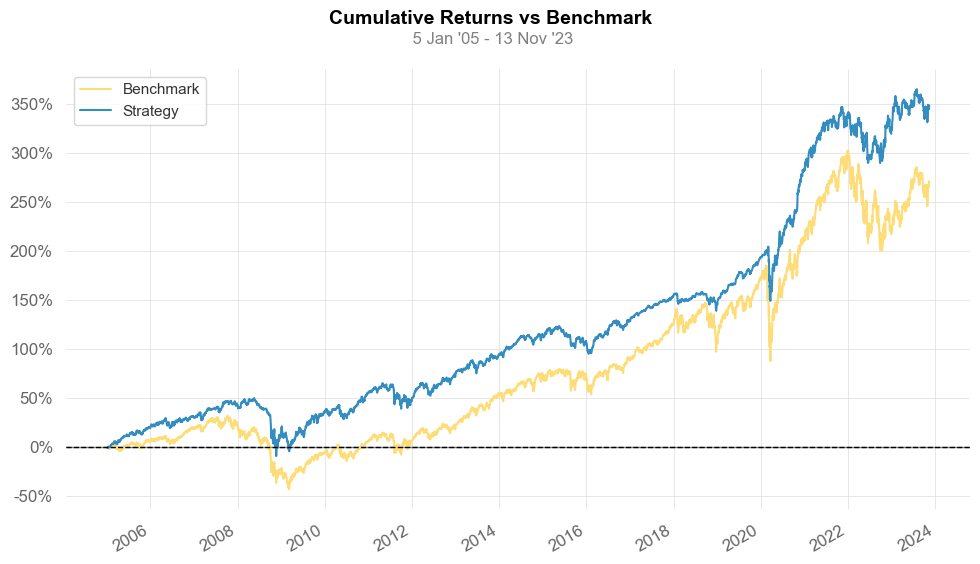

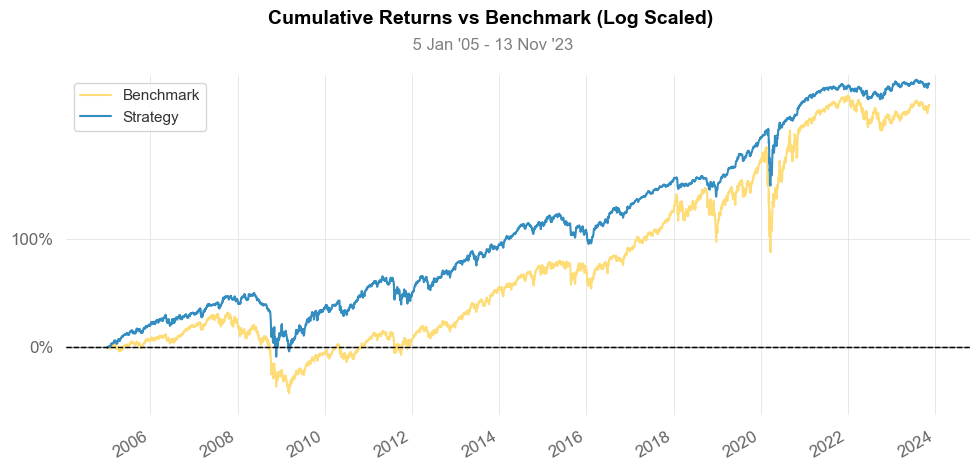

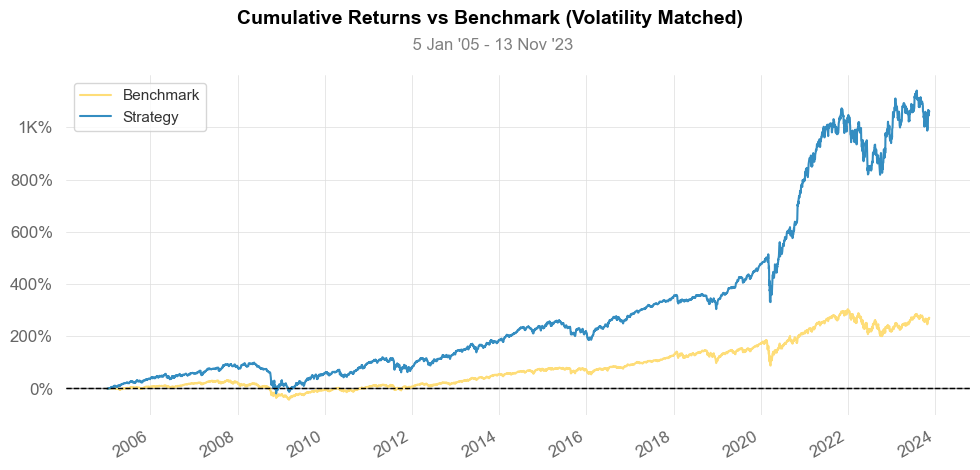

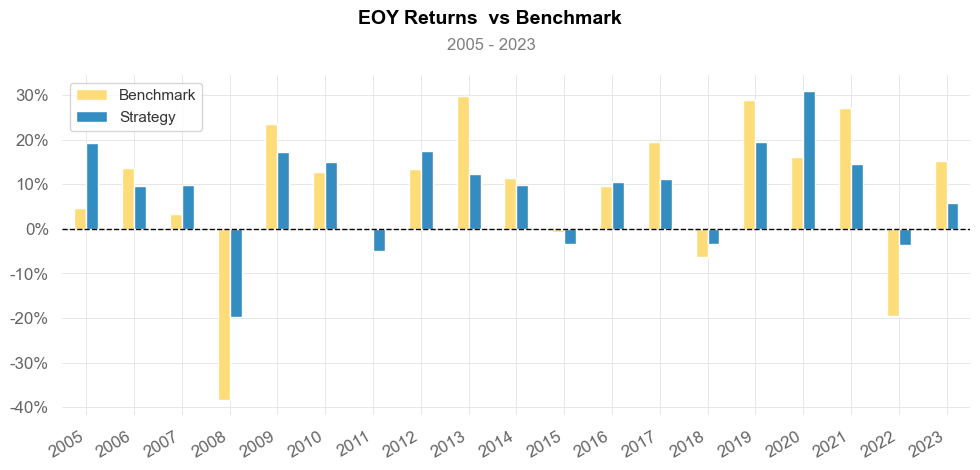

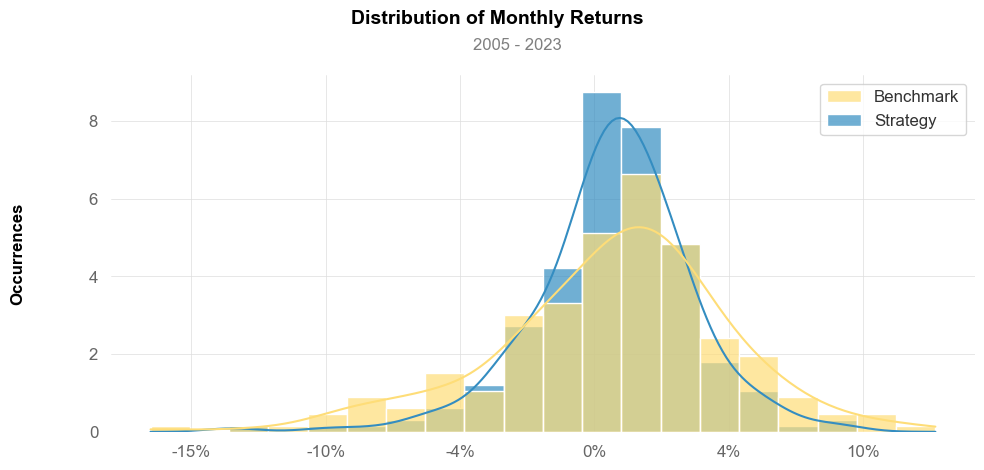

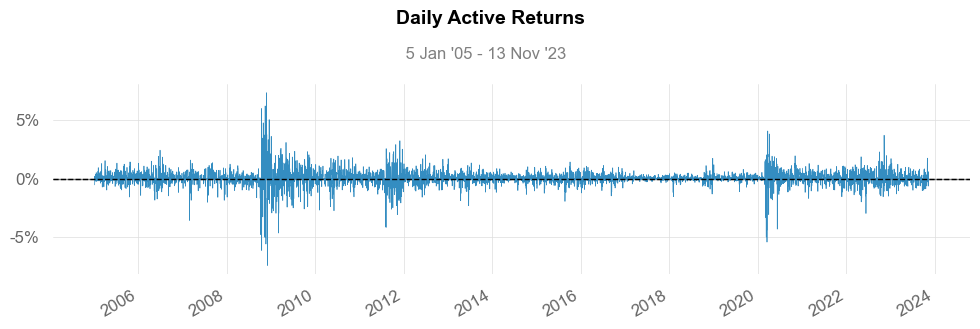

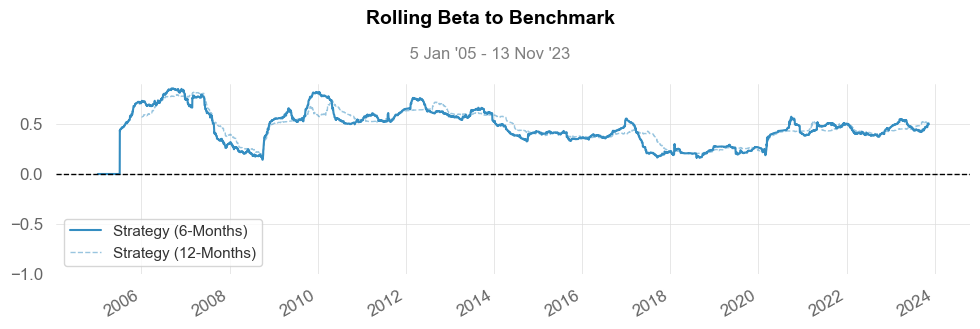

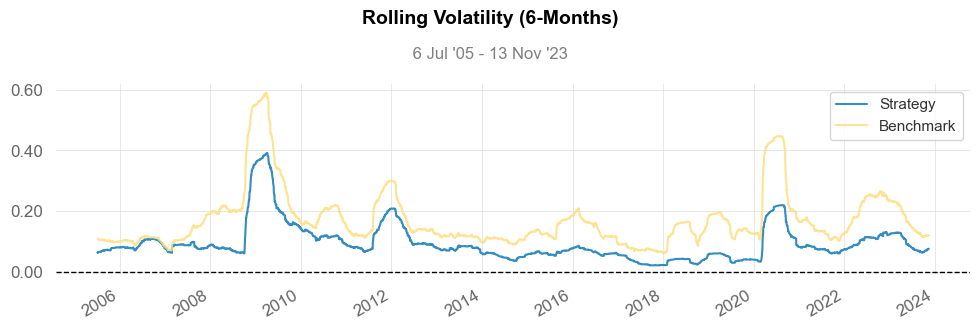

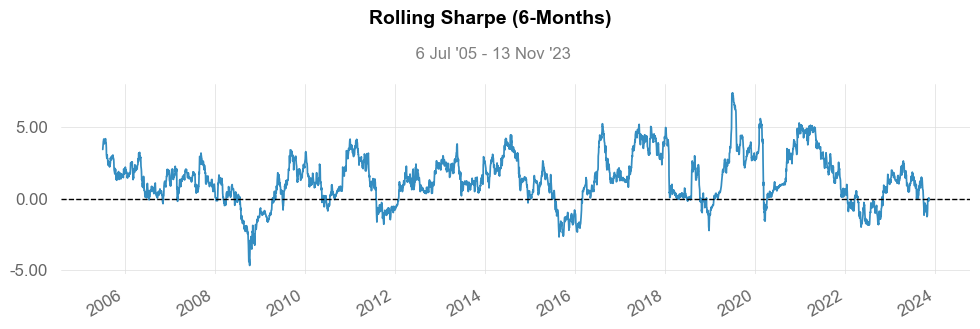

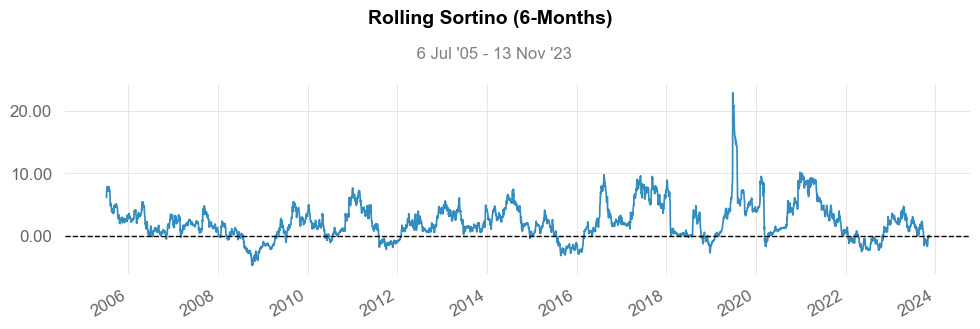

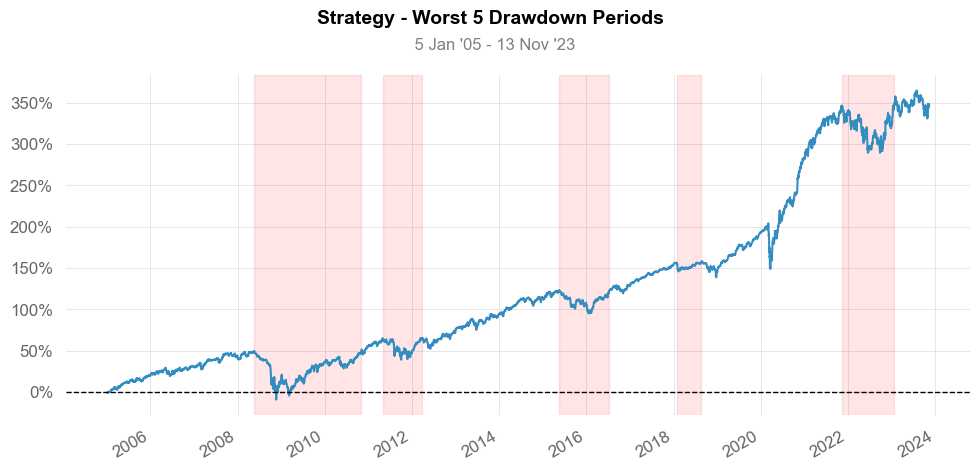

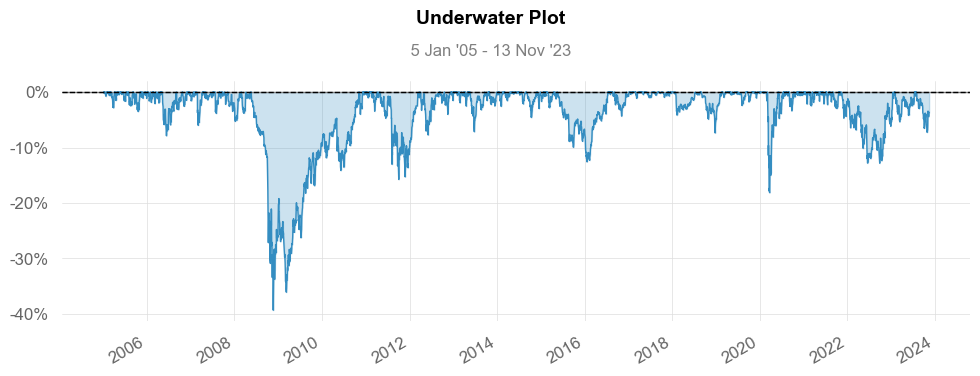

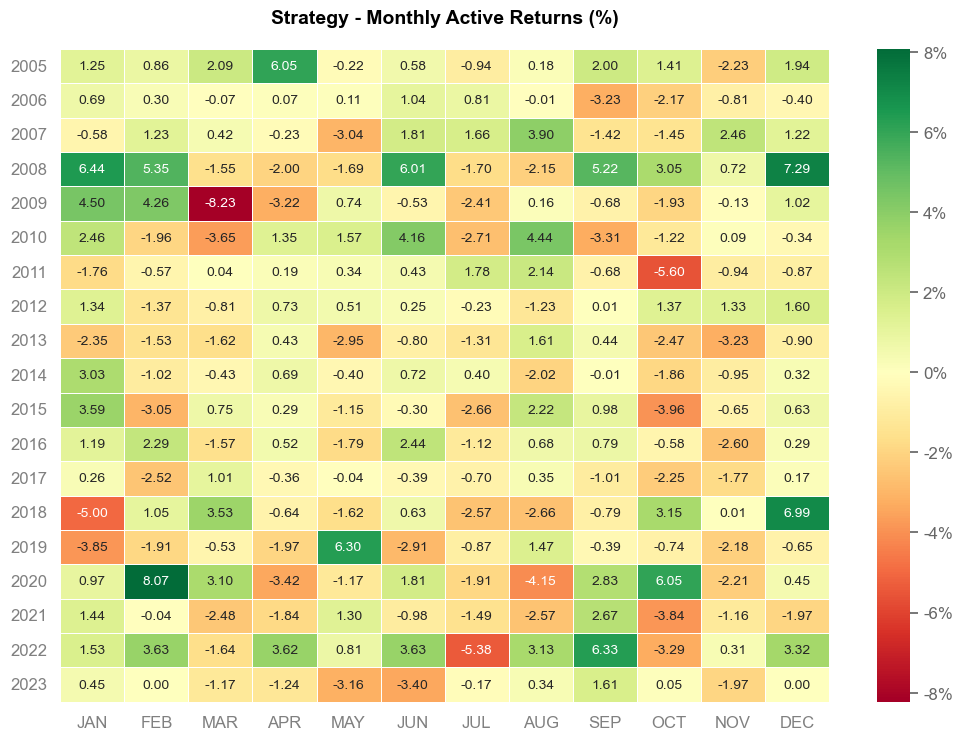

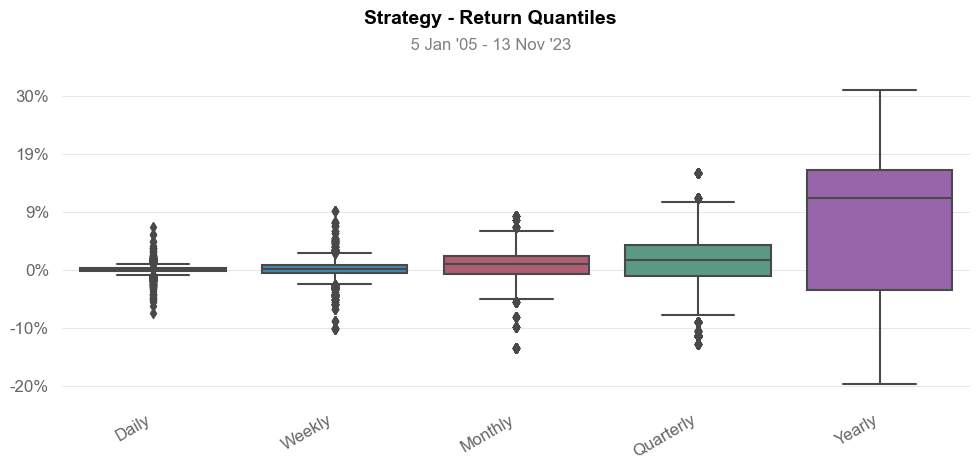

In [65]:
ret = (port * past_weight).sum(axis=1)
qs.reports.full(ret, 'SPY', figsize=(10, 10))

In [24]:
past_weight = pd.read_parquet(get_strategy_port_data() / 'data_weight.parquet.brotli')

# Live

In [3]:
# Get tickers
df_tickers = pd.read_parquet(get_strategy_port_data() / 'data_stock.parquet.brotli')
category = df_tickers.reset_index().groupby('category')['ticker'].apply(list).to_dict()
cp_ticker = category['cp']
util_ticker = category['util']
hc_ticker = category['hc']
tech_ticker = category['tech']
ind_ticker = category['ind']
re_ticker = category['re']
mat_ticker = category['mat']
cd_ticker = category['cd']
eng_ticker = category['eng']
bond_ticker = category['bond']
com_ticker = category['com']
fin_ticker = category['fin']

# Get macro
inflation = pd.read_parquet(get_strategy_port_data() / 'data_if.parquet.brotli')
interest = pd.read_parquet(get_strategy_port_data() / 'data_ir.parquet.brotli')
ffund = pd.read_parquet(get_strategy_port_data() / 'data_ffund.parquet.brotli')
unemploy = pd.read_parquet(get_strategy_port_data() / 'data_ur.parquet.brotli')

# Get port
past_port = pd.read_parquet(get_strategy_port_data() / 'data_port.parquet.brotli')

# Get weight
past_weight = pd.read_parquet(get_strategy_port_data() / 'data_weight.parquet.brotli')

# Get price
past_price = pd.read_parquet(get_strategy_port_data() / 'data_price.parquet.brotli')

In [ ]:
# Execute get last price functionality
async def exec_price():
    # Get first valid contract
    async def get_contract(symbol):
        contract = Stock(symbol, 'SMART', 'USD')
        contracts = await ib.reqContractDetailsAsync(contract)
        if contracts:
            qualified_contract = contracts[0].contract
            print(f"Obtained qualified contract for {symbol}: {qualified_contract}")
            return qualified_contract
        else:
            print(f"No qualified contract found for {symbol}")
            return None

    # Get the last closing price of a stock
    async def get_market_data(stock):
        print("-" * 60)
        MAX_RETRIES = 10
        SLEEP_DURATION = 1

        for _ in range(MAX_RETRIES):
            market_data = ib.reqMktData(stock, '', False, False)
            await asyncio.sleep(SLEEP_DURATION)
            if market_data.last:
                print(f"Obtained {stock.symbol} last price")
                print("-" * 60)
                return market_data

        print(f"Failed to get market data for {stock.symbol} after {MAX_RETRIES} consecutive calls.")
        print("-" * 60)
        return None

    async def get_last_price(symbol):
        contract = await get_contract(symbol)
        if not contract:
            return symbol, None
        market_data = await get_market_data(contract)
        if market_data and market_data.last:
            return symbol, market_data.last
        return symbol, None


    # Get stocks
    live = True
    past_data = pd.read_parquet(get_strategy_port_data() / 'data_port.parquet.brotli')
    all_stocks = past_data.columns.tolist()

    # Create a list of coroutines for each stock's closing price fetch
    tasks = [get_last_price(stock_symbol) for stock_symbol in all_stocks]
    # Run all fetch tasks concurrently and gather the symbol-price tuples
    symbol_price_tuples = await asyncio.gather(*tasks)
    # Filter out any tuples where the price is None (this should be None)
    symbol_price_tuples = [t for t in symbol_price_tuples if t[1] is not None]
    # Create DataFrame
    price_all = pd.DataFrame(symbol_price_tuples, columns=['ticker', 'Close'])
    price_all['date'] = pd.to_datetime(past_date)
    price_all = price_all.set_index(['ticker', 'date'])
    price_all = price_all.unstack('ticker')
    price_all.columns = price_all.columns.get_level_values('ticker')
    
    # Disconnect from IB
    ib.disconnect()
    return price_all

In [ ]:
total_price = pd.concat([past_price, present_price], axis=0)
present_port = total_price.pct_change().iloc[-1]
total_port = pd.concat([past_port, present_port], axis=0)

In [67]:
present_weight = create_weight(live=True, port=total_port, tech_ticker=tech_ticker, eng_ticker=eng_ticker, hc_ticker=hc_ticker, 
                               re_ticker=re_ticker, mat_ticker=mat_ticker, fin_ticker=fin_ticker, cd_ticker=cd_ticker,
                               ind_ticker=ind_ticker, util_ticker=util_ticker, cp_ticker=cp_ticker, com_ticker=com_ticker,
                               bond_ticker=bond_ticker)

Calculate inverse vol weights...
Calculate beginning of month weights...
Calculate last week of December weights...
Calculate September weights...
Calculate Halloween weights...
Get Inflation data...
Export data...
Calculate high inflation weights...
Calculate low inflation weights...
Get Interest data...
Export data...
Calculate high interest weights...
Calculate low interest weights...
Get FFund data...
Export data...
Calculate high ffund weights...
Calculate low ffund weights...
Get unemployment data...
Calculate high unemployment weights...
Export weight...
Export tickers...


In [ ]:
total_weight = pd.concat([past_weight, present_weight], axis=0)
total_weight.total_weight(get_strategy_port_data() / 'data_weight.parquet.brotli', compression='brotli')